<a href="https://colab.research.google.com/github/victorhss21/CSV_to_PARQUET/blob/main/tbl_sintetica_haka_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Geração de dados sintéticos (executou com sucesso)

Instalação de dependências:

~~~~python
# Instalando pyarrow
!pip install pandas numpy pyarrow
~~~~

Gerando bases de dados sintética:

~~~~python
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime, timedelta
from concurrent.futures import ProcessPoolExecutor
import os
import warnings
warnings.filterwarnings('ignore')

def generate_base_customers(n_customers, segment_dist, revenue_ranges):
    """Gera a base inicial de clientes usando operações vetorizadas"""

    # Gerar segmentos
    segments = np.random.choice(
        list(segment_dist.keys()),
        size=n_customers,
        p=list(segment_dist.values())
    )

    # Gerar faturamentos vetorialmente
    faturamentos = np.zeros(n_customers)
    for segment in segment_dist.keys():
        mask = segments == segment
        min_rev, max_rev = revenue_ranges[segment]
        faturamentos[mask] = np.random.uniform(
            min_rev,
            max_rev,
            size=mask.sum()
        )

    # Gerar outros atributos vetorialmente
    base_data = {
        'num_id_cliente': np.arange(1, n_customers + 1),
        'segmento': segments,
        'setor_atuacao': np.random.choice(['P1', 'P2', 'P3', 'P4', 'P5', 'P6'], size=n_customers),
        'faturamento_anual': faturamentos,
        'tempo_de_vida_meses': np.random.randint(1, 241, size=n_customers),
        'status_rf': np.random.choice(
            ['ativa', 'inativa', 'suspensa', 'inapta', 'baixada'],
            size=n_customers,
            p=[0.60, 0.10, 0.10, 0.10, 0.10]
        )
    }

    return pd.DataFrame(base_data)

def generate_safra(args):
    """Gera dados para uma safra específica"""
    active_customers, anomes, idx = args
    n_customers = len(active_customers)

    # Gerar volumes financeiros vetorialmente
    cash_in = np.random.lognormal(
        mean=np.log(active_customers['faturamento_anual'].values/12),
        sigma=0.5
    )

    # Volumes de crédito
    vol_total = np.random.uniform(0.1, 0.5, size=n_customers) * cash_in

    # Gerar volumes por produto vetorialmente
    produtos_volumes = np.random.dirichlet(
        np.ones(5),
        size=n_customers
    ) * vol_total.reshape(-1, 1)

    # Calcular inadimplência vetorialmente
    vol_vencido = np.random.uniform(0, 0.2, size=n_customers) * vol_total

    # Calcular ratings vetorialmente
    alavancagem = vol_total / cash_in
    inadimplencia = vol_vencido / vol_total

    ratings = np.full(n_customers, 'R1', dtype='object')
    ratings[(inadimplencia > 0.15) | (alavancagem > 0.4)] = 'R5'
    ratings[(inadimplencia > 0.10) | (alavancagem > 0.3)] = 'R4'
    ratings[(inadimplencia > 0.05) | (alavancagem > 0.2)] = 'R3'
    ratings[(inadimplencia > 0.02) | (alavancagem > 0.1)] = 'R2'

    # Criar DataFrame da safra
    safra_data = {
        'anomes': np.full(n_customers, anomes),
        'num_id_cliente': active_customers['num_id_cliente'].values,
        'segmento': active_customers['segmento'].values,
        'setor_atuacao': active_customers['setor_atuacao'].values,
        'vol_cash_in_total': cash_in,
        'vol_cg': produtos_volumes[:, 0],
        'vol_lis': produtos_volumes[:, 1],
        'vol_repasse': produtos_volumes[:, 2],
        'vol_giro': produtos_volumes[:, 3],
        'vol_reneg': produtos_volumes[:, 4],
        'vol_total_bacen': vol_total,
        'faturamento_anual': active_customers['faturamento_anual'].values,
        'vol_vencido_bacen': vol_vencido,
        'status_rf': active_customers['status_rf'].values,
        'status_rating': ratings,
        'tempo_de_vida_meses': active_customers['tempo_de_vida_meses'].values + idx
    }

    df_safra = pd.DataFrame(safra_data)

    # Salvar em parquet
    table = pa.Table.from_pandas(df_safra)
    pq.write_table(table, f'safra_{anomes}.parquet')

    return df_safra

def generate_customer_database():
    """Função principal de geração da base"""

    # Configurações
    n_customers = 1500000
    n_months = 8
    churn_rate = 0.02

    # Criar diretório para os arquivos
    if not os.path.exists('safras'):
        os.makedirs('safras')

    # Gerar datas das safras
    base_date = datetime(2024, 12, 1)
    dates = [(base_date - timedelta(days=30*i)).strftime("%Y%m") for i in range(n_months)]
    dates.reverse()

    # Definir distribuições
    segment_dist = {
        'A': 0.15,
        'B': 0.15,
        'C': 0.23,
        'D': 0.25,
        'E': 0.22
    }

    revenue_ranges = {
        'A': (80_000_000, 100_000_000),
        'B': (60_000_000, 80_000_000),
        'C': (40_000_000, 60_000_000),
        'D': (20_000_000, 40_000_000),
        'E': (1_000_000, 20_000_000)
    }

    # Gerar base de clientes
    print("Gerando base inicial de clientes...")
    base_df = generate_base_customers(n_customers, segment_dist, revenue_ranges)

    # Processar safras em paralelo
    print("Processando safras em paralelo...")
    active_customers = base_df.copy()

    with ProcessPoolExecutor(max_workers=4) as executor:
        safra_args = []
        for idx, anomes in enumerate(dates):
            # Aplicar churn
            if idx > 0:
                n_keep = int(len(active_customers) * (1 - churn_rate))
                active_customers = active_customers.sample(n=n_keep)

            safra_args.append((active_customers.copy(), anomes, idx))

        # Executar processamento paralelo
        results = list(executor.map(generate_safra, safra_args))

    print("Gerando estatísticas...")
    # Concatenar resultados para estatísticas
    final_df = pd.concat(results)

    # Imprimir estatísticas
    print(f"\nTotal de registros: {len(final_df)}")
    print(f"\nDistribuição por segmento:\n{final_df['segmento'].value_counts(normalize=True)}")
    print(f"\nDistribuição por status RF:\n{final_df['status_rf'].value_counts(normalize=True)}")
    print(f"\nDistribuição por rating:\n{final_df['status_rating'].value_counts(normalize=True)}")

    print("\nArquivos gerados:")
    for anomes in dates:
        print(f"safra_{anomes}.parquet")

if __name__ == "__main__":
    generate_customer_database()
~~~~

Carregando dados em memória para realização de análises/procedimentos:


In [1]:
import pandas as pd
import pyarrow.parquet as pq
import glob
from typing import List, Union

def load_safras(
    safras: Union[List[str], str] = 'all',
    colunas: List[str] = None,
    filtros: List[tuple] = None
) -> pd.DataFrame:
    """
    Carrega e empilha safras específicas dos arquivos parquet.

    Args:
        safras: Lista de safras (ex: ['202401', '202402']) ou 'all' para todas
        colunas: Lista de colunas para carregar (None para todas)
        filtros: Lista de tuplas com filtros no formato [(coluna, operador, valor)]
                Operadores suportados: '==', '>', '<', '>=', '<=', '!='

    Returns:
        DataFrame com as safras empilhadas
    """
    # Listar todos os arquivos parquet disponíveis
    arquivos = glob.glob('safra_*.parquet')

    # Filtrar arquivos por safras desejadas
    if safras != 'all':
        arquivos = [f for f in arquivos if any(s in f for s in safras)]

    if not arquivos:
        raise ValueError("Nenhum arquivo encontrado com as safras especificadas")

    # Criar filtros do pyarrow se necessário
    pa_filtros = None
    if filtros:
        pa_filtros = []
        for coluna, operador, valor in filtros:
            if operador == '==':
                pa_filtros.append((coluna, '=', valor))
            else:
                pa_filtros.append((coluna, operador, valor))

    # Carregar e empilhar os dados
    dfs = []
    for arquivo in arquivos:
        try:
            # Ler apenas as colunas necessárias e aplicar filtros
            df = pq.read_table(
                arquivo,
                columns=colunas,
                filters=pa_filtros
            ).to_pandas()

            dfs.append(df)

            print(f"Arquivo {arquivo} carregado: {len(df)} registros")

        except Exception as e:
            print(f"Erro ao carregar {arquivo}: {str(e)}")

    if not dfs:
        raise ValueError("Nenhum dado foi carregado")

    # Empilhar todos os DataFrames
    df_final = pd.concat(dfs, ignore_index=True)

    print(f"\nTotal de registros carregados: {len(df_final):,}")
    print(f"Memória utilizada: {df_final.memory_usage().sum() / 1024**2:.2f} MB")

    return df_final

# Exemplo de uso:
if __name__ == "__main__":
    # # Opção 1: Carregar todas as safras
    # df = load_safras()

    # # Opção 2: Carregar safras específicas
    df = load_safras(['202406', '202407', '202408','202409','202410','202411','202412'])

    # # Opção 3: Carregar apenas algumas colunas
    # df = load_safras(
    #     colunas=['anomes','num_id_cliente','segmento','setor_atuacao','vol_cash_in_total','vol_cg','vol_lis','vol_repasse','vol_giro','vol_reneg','vol_total_bacen','faturamento_anual','vol_vencido_bacen','status_rf','status_rating','tempo_de_vida_meses']
    # )

    # # Opção 4: Carregar com filtros
    # df = load_safras(
    #     filtros=[
    #         ('segmento', '==', 'A'),
    #         ('vol_total_bacen', '>', 1000000)])

Arquivo safra_202411.parquet carregado: 1328762 registros
Arquivo safra_202409.parquet carregado: 1383552 registros
Arquivo safra_202406.parquet carregado: 1470000 registros
Arquivo safra_202410.parquet carregado: 1355880 registros
Arquivo safra_202408.parquet carregado: 1411788 registros
Arquivo safra_202412.parquet carregado: 1302186 registros
Arquivo safra_202407.parquet carregado: 1440600 registros

Total de registros carregados: 9,692,768
Memória utilizada: 1183.20 MB


In [2]:
# Verifica quais variáveis estão ocupando mais memória
import sys
for var in dir():
    if not var.startswith('_'):  # ignora variáveis privadas
        size = sys.getsizeof(eval(var))
        if size > 1000:  # mostra apenas variáveis maiores que 1KB
            print(f"{var}: {size/1024/1024:.2f} MB")

df: 3603.20 MB


~~~~python
# Deletando daframes da memória
del df2, df3, df4
~~~~

In [3]:
# importa numpy
import numpy as np
# Cálculo vetorizado para métricas financeiras
df['alavancagem'] = df['vol_total_bacen'] / df['vol_cash_in_total']
df['inadimplencia'] = df['vol_vencido_bacen'] / (df['vol_total_bacen'] + df['vol_vencido_bacen'] + 1e-12)

# Tratamento de divisão por zero
df['alavancagem'] = df['alavancagem'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['inadimplencia'] = df['inadimplencia'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Atribuição vetorizada do rating usando np.select
conditions = [
    (df['inadimplencia'] > 0.15) | (df['alavancagem'] > 0.4),  # R5
    (df['inadimplencia'] > 0.10) | (df['alavancagem'] > 0.3),  # R4
    (df['inadimplencia'] > 0.05) | (df['alavancagem'] > 0.2),  # R3
    (df['inadimplencia'] > 0.02) | (df['alavancagem'] > 0.1)   # R2
]

choices = ['R5', 'R4', 'R3', 'R2']

df['status_rating'] = np.select(conditions, choices, default='R1')

# drop das colunas auxiliares
df.drop(['alavancagem','inadimplencia'], axis=1, inplace=True)

In [4]:
# Renomeando colunas para facilitar adequação no código do Hakaton
df.columns = ['anomes', 'num_cpf_cnpj',	'segmento',	'personas',	'vol_cash_in_total_sv',	'vol_cg',	'vol_lis',	'vol_repasse',	'vol_giro',	'vol_reneg',	'vol_total_bacen',	'faturamento_anual',	'vol_vencido_bacen',	'status_receita federal',	'status_gs',	'tempo_de_vida_meses']

In [5]:
# Criando base simulada do Hackathon
df_hack = df[['anomes', 'num_cpf_cnpj',	'segmento',	'personas',	'vol_cash_in_total_sv',	'vol_total_bacen',	'faturamento_anual',	'vol_vencido_bacen',	'status_receita federal',	'status_gs',	'tempo_de_vida_meses']]
# Criando base simulada de sof e sor
df_sor_sof = df[['anomes', 'num_cpf_cnpj', 'vol_cash_in_total_sv',		'vol_cg',	'vol_lis',	'vol_repasse',	'vol_giro',	'vol_reneg']].rename({'num_cpf_cnpj':'cnpj', 'vol_cash_in_total_sv':'vol_cash_in_total'}, axis=1)

In [6]:
# Verifica quais variáveis estão ocupando mais memória
import sys
for var in dir():
    if not var.startswith('_'):  # ignora variáveis privadas
        size = sys.getsizeof(eval(var))
        if size > 1000:  # mostra apenas variáveis maiores que 1KB
            print(f"{var}: {size/1024/1024:.2f} MB")

df: 3603.20 MB
df_hack: 3233.45 MB
df_sor_sof: 1100.01 MB


In [7]:
# del df_amostra2_treino, df_amostra2_validacao, df_amostra_treino, df_amostra_treino_final, df_amostra_validacao, df_principal, df_processed, df_sample_teste, df_sample_treino

## 00. Imports de Libs & Configurações


~~~~python
# Instala awswnagler
!pip install awswrangler -q
# Importa awswnagler
import awswrangler as wr
~~~~

In [8]:
# Imports das principais libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Ajuste para melhor visualização das colunas
pd.set_option('display.max_columns', None)
# Ajuste para melhor visualização do formato dos números nas tabelas
pd.options.display.float_format = '{:.2f}'.format

## 01. Carregamento dos dados

``Escript python para carregamento de dados utilizando AWSWangler``

<mark>Suplemento de informações (variáveis SoR de produtos específicos e SoF) é "Nice To Have"</mark>

Dados a serem carregados:


* Tabela do Hackathon (a partir do S3): `df`
* Tabela com informações de SoR/SoF (a partir do S3): `df_sor_sof`

Cruzamento a serem feito:

* `df` e `df_sor_sof`



~~~~python
# Carregamento dos dados do hackathon
df_hack = wr.athena.read_sql_query("SELECT * FROM my_table", database="my_db", ...)
~~~~

In [10]:
# Join da tabele de SoF e SoR com a tabela do Hackathon
df = df_hack.merge(df_sor_sof, left_on=['anomes','num_cpf_cnpj'], right_on=['anomes','cnpj'], how='left')

In [11]:
# Higienização de memória
del df_sor_sof, df_hack

## 02. Análise exploratória dos dados

### 2.1. Report via Pandas Profilling

> Utilização da biblioteca Ydata-Profilling para ganho de produtividade [(Ref.)](https://docs.profiling.ydata.ai/4.6/features/big_data/#pyspark)

````python
# Instala ydata-profilling
!pip install -U ydata-profiling -q
````

In [12]:
# Instala ydata-profilling
import sys
!{sys.executable} -m pip install -U ydata-profiling[notebook]
!pip install jupyter-contrib-nbextensions

In [13]:
# Instala e ativa nbextension para interaão via HTML com report
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [14]:
# Import de libs
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

In [15]:
# # Criando report com ydata-profilling (versão otimizada para avaliar grande volume de dados: minimal=True)
# profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)
# # Exportando report
# profile.to_file("tbl_hack_report_eda.html")

````python
# Renderizando report no próprio notebook
profile
````

### 2.2. Análise de Correlação

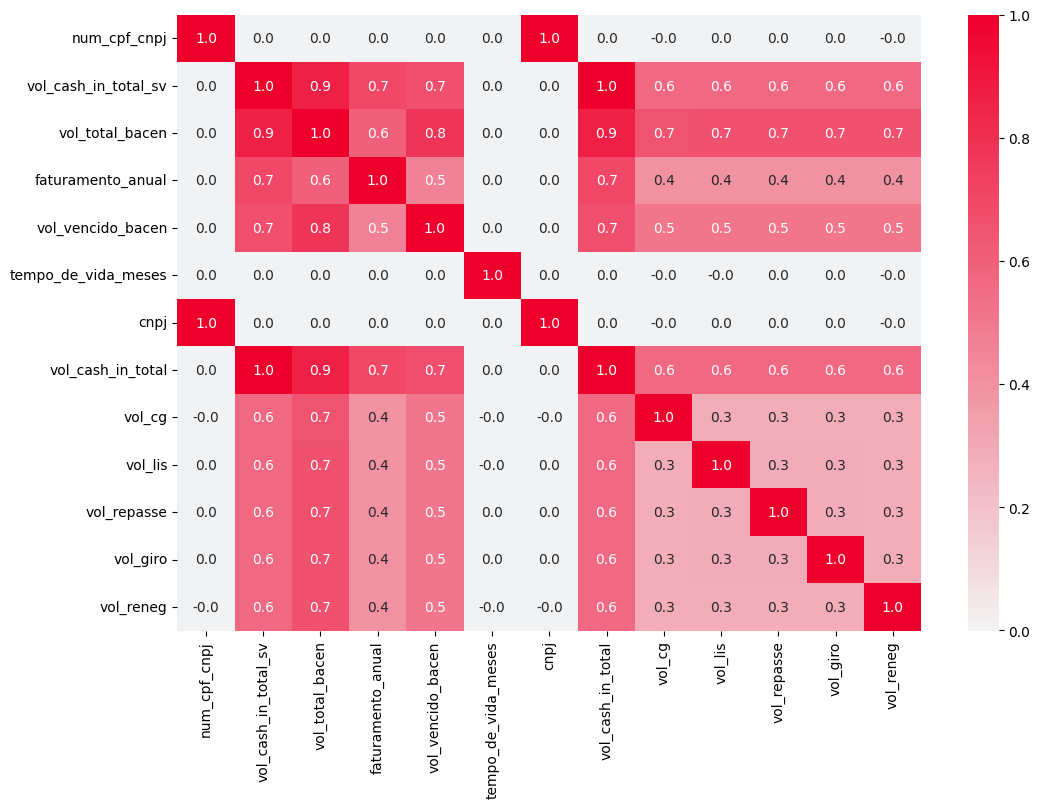

In [16]:
# Define anomes para realização da análise
anomes = 202411 # Referência M0 que iremos utilizar para análise

# Configurações visuais
cmap = sns.diverging_palette(h_neg=240,h_pos=10,s=100,as_cmap=True)

# Definir o tamanho da figura
plt.figure(figsize=(12, 8))  # Aumente os valores para tamanhos maiores

# Plotando Heatmap
sns.heatmap(df.query(f'anomes == "{anomes}"').select_dtypes(include=['number']).corr(method='pearson'), cmap=cmap, annot=True, fmt='.1f',center=0);

> **Comentários:**
- Considerando que a base de dados é bastante grande e não iremos utilizar toda a base, optamos por analisar aperar o histórico útil (202411 a 202406) e apenas as variáveis que passarem em nosso filro inicial
- Notamos que algumas variáveis possuem bastante inconsistências para as safras mais recentes. Dado o tempo, iremos optar por simplesmente não utiliza-las
- Identificamos forte correlação entre algumas variáveis, detacam-se:
- Da mesma forma, notamos que não há uma correlação muito alta entre Cash-In e Faturamento Eleito (esperávamos que tivesse)
- Notamos que existem clientes sem classificação de status G

## 03. Separação do conjunto de dados para Treino/Validação

> Embora o modelo possa não ser uma solução com aplicação 100% de Machine Learning, optamos por fazer um recorte da base para eventuais análises de coerência do método desenvolvido.

Definção da função para geração de amostra de validação estratificada:

In [17]:
# import train_test_split
from sklearn.model_selection import train_test_split

# Define função de amostra estratificada
def criar_amostras_temporais_stratificadas(df, seed=42, test_size=0.1):
    """
    Cria amostras temporais estratificadas preservando histórico completo dos CNPJs

    Parâmetros:
    df (pd.DataFrame): DataFrame completo com histórico temporal
    seed (int): Semente para reprodutibilidade

    Retorno:
    (pd.DataFrame, pd.DataFrame): df_amostra_treino, df_amostra_validacao
    """

    # Passo 1: Identificar o último segmento de CADA CNPJ (mesmo que inativo no último mês)
    ultimo_segmento_por_cnpj = (
        df.sort_values('anomes')
        .groupby('num_cpf_cnpj')
        .tail(1)
        [['num_cpf_cnpj', 'segmento']]
    )

    # Passo 2: Juntar com todos os CNPJs existentes
    todos_cnpjs = pd.DataFrame({'num_cpf_cnpj': df['num_cpf_cnpj'].unique()})
    df_estratificacao = todos_cnpjs.merge(
        ultimo_segmento_por_cnpj,
        on='num_cpf_cnpj',
        how='left'
    )

    # Preencher segmentos faltantes (CNPJs sem histórico no último mês)
    df_estratificacao['segmento'] = df_estratificacao['segmento'].fillna('DESCONHECIDO')

    # Passo 3: Dividir estratificadamente
    train_cnpjs, val_cnpjs = train_test_split(
        df_estratificacao,
        test_size=test_size,
        stratify=df_estratificacao['segmento'],
        random_state=seed
    )

    # Passo 4: Criar datasets finais com histórico completo
    df_amostra_treino = df[df['num_cpf_cnpj'].isin(train_cnpjs['num_cpf_cnpj'])]
    df_amostra_validacao = df[df['num_cpf_cnpj'].isin(val_cnpjs['num_cpf_cnpj'])]

    # Passo 5: Validação
    print("\nValidação:")
    print(f"Total CNPJs original: {len(todos_cnpjs)}")
    print(f"CNPJs treino: {len(train_cnpjs)}")
    print(f"CNPJs validação: {len(val_cnpjs)}")
    print(f"CNPJs faltantes: {len(todos_cnpjs) - len(train_cnpjs) - len(val_cnpjs)}")

    validar_proporcoes(df_amostra_treino, df_amostra_validacao, df_estratificacao)

    return df_amostra_treino, df_amostra_validacao

def validar_proporcoes(df_treino, df_validacao, df_estratificacao):
    """Validação atualizada"""
    # Proporções esperadas
    prop_original = df_estratificacao['segmento'].value_counts(normalize=True).to_dict()

    # Proporções obtidas
    prop_treino = (
        df_treino.drop_duplicates('num_cpf_cnpj')['segmento']
        .value_counts(normalize=True)
        .to_dict()
    )

    prop_validacao = (
        df_validacao.drop_duplicates('num_cpf_cnpj')['segmento']
        .value_counts(normalize=True)
        .to_dict()
    )

    print("\nComparação de proporções:")
    for segmento in prop_original:
        print(f"\nSegmento {segmento}:")
        print(f"Original: {prop_original[segmento]:.1%}")
        print(f"Treino: {prop_treino.get(segmento, 0):.1%}")
        print(f"Validação: {prop_validacao.get(segmento, 0):.1%}")

    # Verificação de cobertura total
    cnpjs_originais = set(df_estratificacao['num_cpf_cnpj'])
    cnpjs_processados = set(df_treino['num_cpf_cnpj']).union(set(df_validacao['num_cpf_cnpj']))
    print(f"\nCNPJs não alocados: {len(cnpjs_originais - cnpjs_processados)}")

Geração da amostra de validação 1 (Conjunto de CNPJs separados para validação e seus respectivos históricos):

In [18]:
# Divisão treino-validação 90/10 estratificada
df_amostra_treino, df_amostra1_validacao = criar_amostras_temporais_stratificadas(df=df,seed=42, test_size=0.1)


Validação:
Total CNPJs original: 1470000
CNPJs treino: 1323000
CNPJs validação: 147000
CNPJs faltantes: 0

Comparação de proporções:

Segmento D:
Original: 25.0%
Treino: 25.0%
Validação: 25.0%

Segmento C:
Original: 23.1%
Treino: 23.1%
Validação: 23.1%

Segmento E:
Original: 22.0%
Treino: 22.0%
Validação: 22.0%

Segmento A:
Original: 15.0%
Treino: 15.0%
Validação: 15.0%

Segmento B:
Original: 15.0%
Treino: 15.0%
Validação: 15.0%

CNPJs não alocados: 0


Geração da amostra de validação 2 (separação do último mês de ref. da base de dados, para avaliação de coerência da classificação):

In [19]:
# Especifica número de meses subsequentes a M0 a serem separados para validação
n_meses_validacao = 1

In [20]:
# Criar uma cópia explícita do DataFrame
df_amostra_treino = df_amostra_treino.copy()

# Converter a coluna anomes para string primeiro (caso seja numérica)
df_amostra_treino.loc[:, 'anomes'] = df_amostra_treino['anomes'].astype(str)

# Converter para datetime com o formato correto YYYYMM
df_amostra_treino.loc[:, 'anomes'] = pd.to_datetime(
    df_amostra_treino['anomes'],
    format='%Y%m'  # Formato correto para datas como "202411"
)

# Ordenar por data corretamente
df_amostra_treino = df_amostra_treino.sort_values('anomes')

# Identificar últimos N meses (agora usando datetime)
ultimas_datas = df_amostra_treino['anomes'].unique()
list_n_menses_validacao = np.sort(ultimas_datas)[-n_meses_validacao:]

# Criar máscara booleana
mask_validacao = df_amostra_treino['anomes'].isin(list_n_menses_validacao)

# Separar datasets
df_amostra2_validacao = df_amostra_treino.loc[mask_validacao, :].copy()
df_amostra_treino_final = df_amostra_treino.loc[~mask_validacao, :].copy()

Em resumo:

In [21]:
print(f'Conjunto de dados indiciais (df):                         {df.shape}')
print('-----------------------------------------------------------------------')
print(f'Conjunto de dados de treino parcial (df_amostra_treino):  {df_amostra_treino.shape}')
print('-----------------------------------------------------------------------')
print(f'Conjunto de dados de treino (df_amostra_treino_final):    {df_amostra_treino_final.shape}')
print(f'Conjunto de dados de validação 1 (df_amostra1_validacao):   {df_amostra1_validacao.shape}')
print(f'Conjunto de dados de validação 2 (df_amostra2_validacao):   {df_amostra2_validacao.shape}')

Conjunto de dados indiciais (df):                         (9692768, 18)
-----------------------------------------------------------------------
Conjunto de dados de treino parcial (df_amostra_treino):  (8723723, 18)
-----------------------------------------------------------------------
Conjunto de dados de treino (df_amostra_treino_final):    (7551673, 18)
Conjunto de dados de validação 1 (df_amostra1_validacao):   (969045, 18)
Conjunto de dados de validação 2 (df_amostra2_validacao):   (1172050, 18)


In [22]:
# Exportando bases para Parquet
df_amostra_treino_final.to_parquet('df_amostra_treino_final.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_amostra_treino_final' exportado como Parquet")

df_amostra1_validacao.to_parquet('df_amostra1_validacao.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_amostra1_validacao' exportado como Parquet")

df_amostra2_validacao.to_parquet('df_amostra2_validacao.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_amostra2_validacao' exportado como Parquet")

DataFrame 'df_amostra_treino_final' exportado como Parquet
DataFrame 'df_amostra1_validacao' exportado como Parquet
DataFrame 'df_amostra2_validacao' exportado como Parquet


In [23]:
# Higienização de memória
del df_amostra2_validacao, df_amostra1_validacao

## 04. Tratamento dos dados

> Tratamento dos dados faltantes e espúrios; seleção de variáveis; criação de novas variáveis e suplementação da informações (se possível)

### 4.1 Seleçao das features a serem utilizadas

Tendo em vista a alta dimensionalidade da base, o grupo selecionou um conjunto de variáveis consideradas mais relevantes para a determinação do momento de vida dos clientes, assim como um recorte de tempo para análise (6 meses):

In [24]:
# Selecionano colunas de interesse
df_amostra_treino_final = df_amostra_treino_final[['anomes','num_cpf_cnpj','segmento','personas','vol_cash_in_total','vol_cg','vol_lis','vol_repasse','vol_giro','vol_reneg','vol_total_bacen','faturamento_anual','vol_vencido_bacen','status_receita federal','status_gs','tempo_de_vida_meses']]

In [25]:
# Higienização de memória
del df_amostra_treino

*(essas variáveis foram definidas após o merge dos conhecimentos de negócios, expertises e hipóteses sobre a explicabilidade do momento de vida das empresas)*

### 4.2 Tratamento dos tipos de dados

Confirmação dos tipos de dados adequados e tratamento, se necessário:

In [26]:
# Define lista de valores possíveis para as variáveis segmento e Gs
lista_segmentos = ['A', 'B', 'C', 'D', 'E']
lista_status_gs = ['R1', 'R2', 'R3', 'R4', 'R5']

In [27]:
# Define função para veirificação e tratamento das variáveis e seus tipos
def fix_data_types(df: pd.DataFrame, lista_segmentos=lista_segmentos, lista_status_gs=lista_status_gs) -> pd.DataFrame:
    """
    Garante os tipos de dados especificados e converte colunas quando necessário
    """
    type_mapping = {
        'num_cpf_cnpj': 'int64',
        'segmento': 'category',
        'personas': 'category',
        'vol_cash_in_total': 'float64',
        'vol_cg': 'float64',
        'vol_lis': 'float64',
        'vol_repasse': 'float64',
        'vol_giro': 'float64',
        'vol_reneg': 'float64',
        'vol_total_bacen': 'float64',
        'faturamento_anual': 'float64',
        'vol_vencido_bacen': 'float64',
        'status_receita federal': 'category',
        'status_gs': 'category',
        'tempo_de_vida_meses': 'int64'
    }

    # Conversão segura de tipos
    for col, dtype in type_mapping.items():
        if col in df.columns:
            try:
                if dtype == 'category':
                    df[col] = df[col].astype('category')
                else:
                    df[col] = df[col].astype(dtype)
            except Exception as e:
                print(f"Erro na conversão de {col} para {dtype}: {str(e)}")
                # Tratamento especial para CNPJ/CPF que podem ter sido lidos como float
                if col == 'num_cpf_cnpj' and df[col].dtype == 'float64':
                    df[col] = df[col].fillna(0).astype('int64').astype('str').str.replace('\.0$', '', regex=True)

    return df

def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Trata valores ausentes de forma diferenciada para numéricas e categóricas
    """
    # Tratamento para numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isna().any():
            # Usa mediana para não ser influenciado por outliers
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)

    # Tratamento para categóricas
    category_cols = df.select_dtypes(include=['category']).columns
    for col in category_cols:
        if df[col].isna().any():
            # Usa moda (valor mais frequente)
            mode_value = df[col].mode().values[0]
            df[col] = df[col].fillna(mode_value)

    return df

def validate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Validações adicionais e transformações necessárias
    """
    # 1. Verifica valores negativos em colunas que devem ser positivas
    positive_columns = [
        'vol_cash_in_total', 'vol_cg', 'vol_lis', 'vol_repasse',
        'vol_giro', 'vol_reneg', 'vol_total_bacen', 'faturamento_anual',
        'vol_vencido_bacen', 'tempo_de_vida_meses'
    ]

    for col in positive_columns:
        if (df[col] < 0).any():
            # print(f"Valores negativos encontrados em {col}. Convertendo para absoluto...")
            # df[col] = df[col].abs()
            print(f"\nValores negativos encontrados em {col}. Convertendo para zero...\n")
            df[col] = 0

    # 2. Validação de CNPJ/CPF
    if df['num_cpf_cnpj'].astype('str').str.len().nunique() > 1: # Verifica se todos os cnpjs/cpfs possuem o mesmo tamanho em número de dígitos (como utilizamos cnpjs raiz, apontará incosistência, porém não configura-se um problema)
        print("\nAtenção: CPF/CNPJ com formatos inconsistentes!\n")

    # 3. Valida categorias conhecidas
    category_checks = {
        'segmento': lista_segmentos,
        'status_gs': lista_status_gs
    }

    for col, allowed in category_checks.items():
        invalid = ~df[col].isin(allowed)
        if invalid.any():
            print(f"\nValores inválidos encontrados em {col}: {df[col][invalid].unique()}\n")
            df[col] = df[col].replace(df[col][invalid].unique(), np.nan)

    return handle_missing_values(df)  # Re-trata missing gerado pela validação

# Uso das funções
def process_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df = fix_data_types(df)
    df = handle_missing_values(df)
    df = validate_data(df)
    return df

In [28]:
# Aplica função de validação e tratamento
df_train_processed = process_pipeline(df_amostra_treino_final)

# Verifica resultados
print("\n---- Informações do DataFrame ----\n")
print(df_train_processed.info())
print("\n---- Quantidade de dados Ausentes ----\n")
print(df_train_processed.isna().sum())

<ipython-input-27-f53630c7880a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)



Atenção: CPF/CNPJ com formatos inconsistentes!


---- Informações do DataFrame ----

<class 'pandas.core.frame.DataFrame'>
Index: 7551673 entries, 2853032 to 1319939
Data columns (total 16 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   anomes                  object  
 1   num_cpf_cnpj            int64   
 2   segmento                category
 3   personas                category
 4   vol_cash_in_total       float64 
 5   vol_cg                  float64 
 6   vol_lis                 float64 
 7   vol_repasse             float64 
 8   vol_giro                float64 
 9   vol_reneg               float64 
 10  vol_total_bacen         float64 
 11  faturamento_anual       float64 
 12  vol_vencido_bacen       float64 
 13  status_receita federal  category
 14  status_gs               category
 15  tempo_de_vida_meses     int64   
dtypes: category(4), float64(9), int64(2), object(1)
memory usage: 777.8+ MB
None

---- Quantidade de dados Ausentes

Avaliando valores únicos das variáveis após o pré-processamento:

In [29]:
# Define função de análise de valores únicos
def analisar_valores_unicos(df, max_exemplos=10, mostrar_nulos=True):
    """
    Imprime valores únicos de cada variável com informações detalhadas

    Parâmetros:
    df (pd.DataFrame): DataFrame a ser analisado
    max_exemplos (int): Número máximo de valores únicos a exibir
    mostrar_nulos (bool): Mostrar contagem de valores nulos
    """

    def descrever_numericos(serie, max_exemplos):
        """Auxiliar para variáveis numéricas"""
        if serie.nunique() <= max_exemplos:
            valores = sorted(serie.dropna().unique())
            print(f"  Valores: {valores}")
        else:
            stats = {
                'Mín': serie.min(),
                'Média': serie.mean(),
                'Mediana': serie.median(),
                'Máx': serie.max()
            }
            print("  Distribuição:")
            for k, v in stats.items():
                print(f"  - {k}: {v:.2f}")

    def descrever_categoricos(serie, max_exemplos):
        """Auxiliar para variáveis categóricas"""
        contagem = serie.value_counts(dropna=False).head(max_exemplos)

        print(f"  Primeiros {max_exemplos} valores:")
        for valor, count in contagem.items():
            freq = count/len(serie)
            print(f"  - '{valor}': {count:,} ({freq:.1%})")

        if len(contagem) < serie.nunique():
            print(f"  ... + {serie.nunique() - len(contagem)} outros valores")

    # Corpo principal da função
    print(f"\n{'-'*50}")
    print(f"Análise de valores únicos - {len(df.columns)} variáveis")
    print(f"{'-'*50}\n")

    for coluna in df.columns:
        # Informações básicas
        n_unicos = df[coluna].nunique()
        tipo = df[coluna].dtype
        n_nulos = df[coluna].isnull().sum()

        # Cabeçalho da variável
        print(f"→ Variável: {coluna}")
        print(f"  Tipo: {tipo} | Valores únicos: {n_unicos:,}", end="")

        # Informações de nulos
        if mostrar_nulos and n_nulos > 0:
            print(f" | Valores nulos: {n_nulos:,} ({n_nulos/len(df):.1%})")
        else:
            print()

        # Análise por tipo de dado
        if n_unicos == 0:
            print("  → Todos os valores ausentes!")
        elif pd.api.types.is_numeric_dtype(df[coluna]):
            descrever_numericos(df[coluna], max_exemplos)
        else:
            descrever_categoricos(df[coluna], max_exemplos)

        print("-"*50)

In [30]:
# Verifica valores únicos por variável
analisar_valores_unicos(df_train_processed, max_exemplos=10)


--------------------------------------------------
Análise de valores únicos - 16 variáveis
--------------------------------------------------

→ Variável: anomes
  Tipo: object | Valores únicos: 6
  Primeiros 10 valores:
  - '2024-06-01 00:00:00': 1,323,000 (17.5%)
  - '2024-07-01 00:00:00': 1,296,571 (17.2%)
  - '2024-08-01 00:00:00': 1,270,632 (16.8%)
  - '2024-09-01 00:00:00': 1,245,220 (16.5%)
  - '2024-10-01 00:00:00': 1,220,328 (16.2%)
  - '2024-11-01 00:00:00': 1,195,922 (15.8%)
--------------------------------------------------


<ipython-input-29-8f67317e8078>:30: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  contagem = serie.value_counts(dropna=False).head(max_exemplos)


→ Variável: num_cpf_cnpj
  Tipo: int64 | Valores únicos: 1,323,000
  Distribuição:
  - Mín: 1.00
  - Média: 749851.41
  - Mediana: 749903.00
  - Máx: 1499999.00
--------------------------------------------------
→ Variável: segmento
  Tipo: category | Valores únicos: 5
  Primeiros 10 valores:
  - 'D': 1,886,643 (25.0%)
  - 'C': 1,740,773 (23.1%)
  - 'E': 1,659,024 (22.0%)
  - 'A': 1,133,133 (15.0%)
  - 'B': 1,132,100 (15.0%)
--------------------------------------------------
→ Variável: personas
  Tipo: category | Valores únicos: 6
  Primeiros 10 valores:
  - 'P6': 1,263,197 (16.7%)
  - 'P2': 1,260,980 (16.7%)
  - 'P5': 1,258,905 (16.7%)
  - 'P4': 1,257,833 (16.7%)
  - 'P1': 1,256,557 (16.6%)
  - 'P3': 1,254,201 (16.6%)
--------------------------------------------------
→ Variável: vol_cash_in_total
  Tipo: float64 | Valores únicos: 7,551,670
  Distribuição:
  - Mín: 13265.51
  - Média: 4279845.13
  - Mediana: 3326282.22
  - Máx: 90487741.45
--------------------------------------------

In [31]:
# Transforma feature anomes de df_train_processed em datetime
df_train_processed['anomes'] = pd.to_datetime(df_train_processed['anomes'], format='%Y%m')

In [32]:
# Exportando bases para Parquet
df_train_processed.to_parquet('df_train_processed.parquet', partition_cols=['anomes'], engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_train_processed' exportado como Parquet")

DataFrame 'df_train_processed' exportado como Parquet


In [33]:
# Higienização de memória
del df_amostra_treino_final

### 4.3. Engenharia de variáveis

> Agora, iremos criar as variáveis que acreditamos serem adequada para modelar o problema.

*Sendo específico, acreditamos que o momento de vida das empreas ativas e em plena operação, seja menos especificado pelo volume atual de crédito/cash, ou mesmo pelo seu atual estado de qualquer outra informação, como rating de crédito (salve excesões de CNPJs inaptos/suspensos/baixados na Receita).*

*Defendemos a tese que variações de volumes, posse, informações cadastrais, ect... sejam muito mais explicativas para o objetivo. Desse modo, seguiremos na contruções de variáveis que capturam variações*


> Para simplificar a abodagem, optamos por utilizar um mês como referência (M0) e avaliar a variação do volume acumulado nos dois meses antecessores a ele com relação ao volume acumulado nos dois meses antecessores de M-3.
>
>Algebricamente, algo como:
>
>
><center>$\frac{(Vol. em M0 + Vol. em M-1 + Vol. em M-2)}{(Vol. em M-3 + Vol. em M-4 + Vol. em M-5)}$
></center>
>
> Realizamos um procedimento semelhante para variáveis categóricas (especialmete Gs), porém utilizando a *moda* dos último três meses e avaliamos a variação ente M0 e M-3.
>
>Ps: Tínhamos um forte interesse em testar uma janela maior de acumulação, porém por motivos de tempo e histórico disponível, optamos por seguir assim.

In [34]:
# Define função de soma móvel com janela de 3M
def soma_movel_3m(df, coluna='vol_cash_in_total'):
    """
    Processa o DataFrame para calcular as somas dos últimos 3 meses a partir de M0 e M3.

    Parâmetros:
      df (pd.DataFrame): DataFrame de entrada contendo as colunas 'anomes', 'num_cpf_cnpj' e a coluna de interesse.
      coluna (str): Nome da coluna utilizada para os cálculos (default: 'vol_cash_in_total').

    Retorna:
      pd.DataFrame: DataFrame contendo as colunas 'anomes', 'num_cpf_cnpj', '{coluna}_m0_3m' e '{coluna}_m3_3m'.
    """
    # Cria uma cópia do DataFrame original
    df = df.copy()

    # Ordena o DataFrame pelos campos 'num_cpf_cnpj' e 'anomes'
    df.sort_values(['num_cpf_cnpj', 'anomes'], inplace=True)

    # Realiza o pivot da tabela, transformando os valores de 'anomes' em colunas
    df_result = df[['anomes', 'num_cpf_cnpj', coluna]].pivot(index='num_cpf_cnpj', columns='anomes', values=coluna)

    # Soma dos últimos 3 meses a partir de M0: soma dos 3 últimos valores (colunas)
    df_result[f'{coluna}_m0_3m'] = df_result.iloc[:, -1] + df_result.iloc[:, -2] + df_result.iloc[:, -3]

    # Soma dos 3 meses anteriores aos últimos 3 meses: soma dos valores das posições -5, -6 e -7
    df_result[f'{coluna}_m3_3m'] = df_result.iloc[:, -5] + df_result.iloc[:, -6] + df_result.iloc[:, -7]

    # Reseta o índice para transformar 'num_cpf_cnpj' em coluna
    df_result.reset_index(inplace=True)

    # Adiciona uma coluna 'anomes' com o valor correspondente à coluna de M0
    df_result['anomes'] = df_result.columns[-3]

    # Seleciona as colunas finais desejadas
    df_return = df_result[['anomes', 'num_cpf_cnpj', f'{coluna}_m0_3m', f'{coluna}_m3_3m']]

    return df_return


In [35]:
# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (cash in)
df_vol_cash_in_total_3m = soma_movel_3m(df=df_train_processed, coluna='vol_cash_in_total')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_cg)
df_vol_cg_3m = soma_movel_3m(df=df_train_processed, coluna='vol_cg')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_lis)
df_vol_lis_3m = soma_movel_3m(df=df_train_processed, coluna='vol_lis')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_repasse)
df_vol_repasse_3m = soma_movel_3m(df=df_train_processed, coluna='vol_repasse')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_giro)
df_vol_giro_3m = soma_movel_3m(df=df_train_processed, coluna='vol_giro')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_reneg)
df_vol_reneg_3m = soma_movel_3m(df=df_train_processed, coluna='vol_reneg')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_total_bacen)
df_vol_total_bacen_3m = soma_movel_3m(df=df_train_processed, coluna='vol_total_bacen')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (faturamento_anual)
df_faturamento_anual_3m = soma_movel_3m(df=df_train_processed, coluna='faturamento_anual')

# Criando variável de soma móvel dos últimos 3 meses para cada CNPJ (vol_vencido_bacen)
df_vol_vencido_bacen_3m = soma_movel_3m(df=df_train_processed, coluna='vol_vencido_bacen')

~~~~python
# Define equivalência númerica dos Gs
dict_gs = {' ' : 0 ,'G1': 1, 'G2+': 2, 'G2-': 3, 'G3+': 4, 'G3-' : 5, 'G4+' : 6, 'G4-' : 7}
~~~~

In [36]:
# Define equivalência númerica dos Gs
dict_gs = {' ' : 0 ,'R1': 1, 'R2': 2, 'R3': 3, 'R4': 4, 'R5' : 5}

In [37]:
# Define função para geração de feature de Gs
def moda_status_gs_3m(df, dict_gs, coluna='status_gs'):
    """
    Processa o DataFrame para calcular a moda dos últimos 3 meses a partir de M0 e dos 3 meses anteriores (M3),
    considerando a tradução dos valores de 'status_gs' conforme o dicionário informado.

    Parâmetros:
      df (pd.DataFrame): DataFrame de entrada contendo as colunas 'anomes', 'num_cpf_cnpj' e a coluna de interesse.
      dict_gs (dict): Dicionário para mapear os valores de 'status_gs' para números.
      coluna (str): Nome da coluna a ser processada (default: 'status_gs').

    Retorna:
      pd.DataFrame: DataFrame com as colunas:
         - 'num_cpf_cnpj'
         - 'anomes': valor correspondente à última coluna pivot (M0)
         - '{coluna}_m0_3m': moda dos valores dos 3 meses a partir de M0
         - '{coluna}_m3_3m': moda dos valores dos 3 meses anteriores a M0 (M3)
    """

    # Import stats a partir do scipy
    from scipy import stats

    # Cria uma cópia do DataFrame original
    df = df.copy()

    # Traduz Gs para números
    df['status_gs'].replace(dict_gs, inplace=True)

    # Ordena o DataFrame pelos campos 'num_cpf_cnpj' e 'anomes'
    df.sort_values(['num_cpf_cnpj', 'anomes'], inplace=True)

    # Realiza o pivot da tabela, transformando os valores de 'anomes' em colunas
    df_result = df[['anomes', 'num_cpf_cnpj', coluna]].pivot(index='num_cpf_cnpj', columns='anomes', values=coluna)

    # Moda dos últimos 3 meses a partir de M0
    df_result[f'{coluna}_m0_3m'] = stats.mode(np.array([df_result.iloc[:, -1].values, df_result.iloc[:, -2].values, df_result.iloc[:, -3].values]).T, keepdims=False, axis=1).mode.astype(int)

    # Moda dos últimos 3 meses a partir de M3 (M0 menos 3)
    df_result[f'{coluna}_m3_3m'] = stats.mode(np.array([df_result.iloc[:, -5].values, df_result.iloc[:, -6].values, df_result.iloc[:, -7].values]).T, keepdims=False, axis=1).mode.astype(int)

    # Reseta o índice para transformar 'num_cpf_cnpj' em coluna
    df_result.reset_index(inplace=True)

    # Adiciona uma coluna 'anomes' com o valor correspondente à coluna de M0
    df_result['anomes'] = df_result.columns[-3]

    # Seleciona as colunas finais desejadas
    df_return = df_result[['anomes', 'num_cpf_cnpj', f'{coluna}_m0_3m', f'{coluna}_m3_3m']]

    return df_return

In [38]:
# Criando variável de moda dos últimos 3 meses para cada CNPJ (status_gs)
df_status_gs_3m = moda_status_gs_3m(df=df_train_processed, dict_gs=dict_gs, coluna='status_gs')

<ipython-input-37-e11c84bb0da6>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['status_gs'].replace(dict_gs, inplace=True)
<ipython-input-37-e11c84bb0da6>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['status_gs'].replace(dict_gs, inplace=True)
<ipython-input-37-e11c84bb0da6>:27: Future

In [39]:
# Criando flag de tempo de vida para modelagem
df_tempo_de_vida_meses = df_train_processed[['anomes', 'num_cpf_cnpj', 'tempo_de_vida_meses']].query('anomes == @pd.to_datetime("2024-11-01")').copy()
df_tempo_de_vida_meses['flag_recem_fundado'] = ((df_tempo_de_vida_meses['tempo_de_vida_meses'] / 12) <= 1).astype(int)

In [40]:
# Criando flag de empresa suspensa/inapta na receita
df_status_inap_susp_bxd = df_train_processed[['anomes', 'num_cpf_cnpj', 'status_receita federal']].query('anomes == @pd.to_datetime("2024-11-01")').copy()
# Cria a flag de empresa inapta/suspensa/baixada
df_status_inap_susp_bxd['flag_inapto_suspenso_baixado'] = (
    (df_status_inap_susp_bxd['status_receita federal'] == 'inapta') |
    (df_status_inap_susp_bxd['status_receita federal'] == 'suspensa') |
    (df_status_inap_susp_bxd['status_receita federal'] == 'baixada')
).astype(int)

In [41]:
# Criando flag de empresa inativa na receita
df_status_inativo = df_train_processed[['anomes', 'num_cpf_cnpj', 'status_receita federal']].query('anomes == @pd.to_datetime("2024-11-01")').copy()
# Cria a flag de empresa inativa
df_status_inativo['flag_inativo'] = (df_status_inativo['status_receita federal'] == 'inativa').astype(int)
# Dropando coluna para não haver duplicidade no join
df_status_inativo.drop('status_receita federal', axis=1, inplace=True)

Após criar as features para modelagem, vamos uni-las em uma única tabela:

In [42]:
# Função para realizar o join de múltiplos DataFrames
def join_multiplos_dataframes(dataframes, on, how='outer'):
    """
    Realiza o join de múltiplos DataFrames com base em uma coluna-chave.

    Parâmetros:
    dataframes (list): Lista de DataFrames a serem unidos.
    on (str): Nome da coluna-chave para o join.
    how (str): Tipo de join ('inner', 'outer', 'left', 'right').

    Retorno:
    pd.DataFrame: DataFrame resultante do join.
    """
    import pandas as pd
    from functools import reduce

    return reduce(lambda left, right: pd.merge(left, right, on=on, how=how), dataframes)

In [43]:
# Lista de dataframes para realizar o join
dataframes = [
  df_train_processed[['anomes', 'num_cpf_cnpj', 'segmento', 'personas']].query('anomes == @pd.to_datetime("2024-11-01")'),
  df_vol_cash_in_total_3m,
  df_vol_cg_3m,
  df_vol_lis_3m,
  df_vol_repasse_3m,
  df_vol_giro_3m,
  df_vol_reneg_3m,
  df_vol_total_bacen_3m,
  df_faturamento_anual_3m,
  df_vol_vencido_bacen_3m,
  df_status_gs_3m,
  df_tempo_de_vida_meses,
  df_status_inap_susp_bxd,
  df_status_inativo]

# Gerando base final com feature tratadas
df_train = join_multiplos_dataframes(dataframes, on=['anomes', 'num_cpf_cnpj'], how='left')

In [44]:
# Visualizando df_train
display(df_train.head())
print('\n')
display(f'Dimensões: {df_train.shape}')

,anomes,num_cpf_cnpj,segmento,personas,vol_cash_in_total_m0_3m,vol_cash_in_total_m3_3m,vol_cg_m0_3m,vol_cg_m3_3m,vol_lis_m0_3m,vol_lis_m3_3m,vol_repasse_m0_3m,vol_repasse_m3_3m,vol_giro_m0_3m,vol_giro_m3_3m,vol_reneg_m0_3m,vol_reneg_m3_3m,vol_total_bacen_m0_3m,vol_total_bacen_m3_3m,faturamento_anual_m0_3m,faturamento_anual_m3_3m,vol_vencido_bacen_m0_3m,vol_vencido_bacen_m3_3m,status_gs_m0_3m,status_gs_m3_3m,tempo_de_vida_meses,flag_recem_fundado,status_receita federal,flag_inapto_suspenso_baixado,flag_inativo
0,2024-11-01,618566,C,P6,12003064.01,11784477.91,1049629.98,1008750.29,816241.29,1801830.86,754413.82,244967.95,1540264.37,901410.29,431447.74,577083.15,4591997.20,4534042.54,132647645.31,132647645.31,294457.43,231664.76,4,5,210,0,ativa,0,0
1,2024-11-01,1226834,E,P4,2834094.49,2109984.35,275127.32,178759.29,61943.20,194753.08,139238.55,66030.49,128896.89,258513.73,49073.52,78760.13,654279.48,776816.71,26316117.49,26316117.49,66922.62,135479.37,3,5,65,0,ativa,0,0
2,2024-11-01,699952,D,P2,6401218.75,9283276.22,198856.28,979384.40,157921.04,1119136.75,82934.25,514717.64,496699.31,345228.15,243875.79,682047.51,1180286.67,3640514.45,83813838.58,83813838.58,33552.67,468728.93,2,5,169,0,suspensa,1,0
3,2024-11-01,189372,D,P5,8396965.76,7714159.83,88921.88,451325.87,569814.89,648763.02,237631.14,469543.40,320666.29,141818.51,1084960.93,146647.90,2301995.13,1858098.69,95159755.73,95159755.73,238051.80,101845.96,5,4,26,0,ativa,0,0
4,2024-11-01,761120,A,P4,42296831.04,34566119.16,1949819.85,2122595.10,1301772.45,1447540.53,3515763.51,719162.68,2205623.54,3114322.18,2582370.64,1273176.23,11555349.99,8676796.72,266079114.06,266079114.06,1253303.63,281508.19,4,4,141,0,ativa,0,0


'Dimensões: (1195922, 29)'

In [45]:
# Exportando bases para Parquet
df_train.to_parquet('df_train.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_train' exportado como Parquet")

DataFrame 'df_train' exportado como Parquet


In [46]:
# Higienização de memória
del df_train_processed

> **OBS:** Tempo de execução do notebook até esta etapa: ~10min

## 05. Classificação Analítica (Heurística)



> Aplicação de regras definidas em grupos, após a consolidação de várias experiências de negócios. O objetivo é classificar o momento de vida com base em 3 principais variáveis que apresentem evidências factuais do momento de vida: Cash-In, Faturamento Eleito e Status G.

Tendo em vista que ainda temos muitas variáveis, iremos priorizar algumas variáves: Cash-In, Gs, tempo de vida e status da receita federal, selecinando apenas elas.

*(posteriormente, o objetivo é identificar a importância das demais features com um modelo de árvore, por exemplo)*

In [48]:
# Especificação das variáveis que serão avaliadas
df = df_train[['anomes','num_cpf_cnpj','segmento','personas','vol_cash_in_total_m0_3m','vol_cash_in_total_m3_3m',
      'status_gs_m0_3m','status_gs_m3_3m','tempo_de_vida_meses','flag_recem_fundado','status_receita federal',
      'flag_inapto_suspenso_baixado','flag_inativo']].copy()

*(Daremos poder maior de decisão ao Cash-In, visto que é uma informação aferida, mais tempestiva e, idealmente, deveria ter uma forte correlação com o Faturamento da empresa)*

In [49]:
# Define funçao de classificação heurística
def process_data(df):
    """
    Processa o DataFrame aplicando as regras descritas:
      - Agrupa os registros por 'segmento' e 'personas'
      - Para cada variável numérica com sufixos _m0_3m e _m3_3m, calcula delta = (m0 / m3) - 1,
        armazenando em 'delta_<variavel>'
      - Calcula percentis (20, 40, 50, 60, 80) por grupo para cada delta e gera novas colunas
      - Cria colunas 'status_delta_<variavel>' com a lógica:
            • Se delta > percentil 60  → "crescimento"
            • Se delta < percentil 40  → "declinio"
            • Caso contrário        → "estavel"
        Com exceção dos grupos em que todas as variações são não-negativas ou não-positivas,
        onde o critério é ajustado conforme solicitado.
      - Cria colunas 'intensidade_delta_<variavel>':
            • Se delta acima do percentil 80 ou abaixo do percentil 20 → "forte"
            • Caso contrário → "moderado"
      - Se existir a variável inteira 'status_gs', calcula seu delta de forma similar e atribui:
            • "saudavel" se o valor em M0 for maior que em M3
            • "nao_saudavel" caso contrário
      - Cria a coluna 'status_momento_empresa' a partir dos flags (caso existam) ou concatenando
        os status de cash_in, status_gs e intensidade de cash_in.
      - Todas as classes geradas serão em letras minúsculas.

    A função retorna o DataFrame com todas as colunas originais e as novas criadas.
    """

    # 1. Identifica as variáveis numéricas com sufixo _m0_3m que possuem a correspondente _m3_3m
    numeric_vars = []
    for col in df.columns:
        if col.endswith('_m0_3m'):
            base = col[:-6]
            if base + '_m3_3m' in df.columns:
                numeric_vars.append(base)

    # 2. Calcula as colunas delta: (valor_m0 / valor_m3) - 1
    for var in numeric_vars:
        df[f'delta_{var}'] = (df[f'{var}_m0_3m'] / df[f'{var}_m3_3m']) - 1

    # 3. Define os agrupamentos e os percentis a serem calculados
    group_keys = ['segmento', 'personas']
    percentis = [20, 40, 50, 60, 80]

    # Para cada variável delta, calcula os percentis por grupo e cria colunas
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        for p in percentis:
            col_name = f'p{p}_{delta_var}'
            df[col_name] = df.groupby(group_keys)[delta_var].transform(lambda x: np.percentile(x, p))

    # 4. Cria as colunas status_delta_<variavel> com classes em minúsculo
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        status_col = f'status_delta_{var}'

        def assign_status(x):
            p60 = np.percentile(x, 60)
            p40 = np.percentile(x, 40)
            # Se não houver variações negativas no grupo:
            if (x >= 0).all():
                return np.where(x < p60, "estavel", "crescimento")
            # Se não houver variações positivas no grupo:
            elif (x <= 0).all():
                return np.where(x < p60, "declinio", "estavel")
            else:
                return np.where(x > p60, "crescimento",
                                np.where(x < p40, "declinio", "estavel"))

        df[status_col] = df.groupby(group_keys)[delta_var].transform(assign_status)

    # 5. Cria as colunas intensidade_delta_<variavel> com classes em minúsculo
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        intensidade_col = f'intensidade_delta_{var}'

        def assign_intensidade(x):
            p80 = np.percentile(x, 80)
            p20 = np.percentile(x, 20)
            return np.where((x > p80) | (x < p20), "forte", "moderado")

        df[intensidade_col] = df.groupby(group_keys, observed=False)[delta_var].transform(assign_intensidade)

    # 6. Processa a variável inteira "status_gs", se existir, com classes em minúsculo
    if 'status_gs_m0_3m' in df.columns and 'status_gs_m3_3m' in df.columns:
        df['delta_status_gs'] = (df['status_gs_m0_3m'] / df['status_gs_m3_3m']) - 1
        df['status_delta_status_gs'] = np.where(
            df['status_gs_m0_3m'] > df['status_gs_m3_3m'],
            "saudavel",
            "nao_saudavel"
        )

    # 7. Cria a coluna "status_momento_empresa" conforme as regras dos flags com prioridade:
    #    flag_inativo > flag_inapto_suspenso_baixado > flag_recem_fundado
    def determine_status(row):
        if row.get('flag_inativo', 0) == 1:
            return "inativa"
        elif row.get('flag_inapto_suspenso_baixado', 0) == 1:
            return "inapta_suspensa_baixada"
        elif row.get('flag_recem_fundado', 0) == 1:
            return "recem_fundada"
        else:
            # Concatena os status referentes à cash_in, status_gs e intensidade de cash_in
            status_cash = row.get('status_delta_vol_cash_in_total', '')
            status_gs = row.get('status_delta_status_gs', '')
            intensidade_cash = row.get('intensidade_delta_vol_cash_in_total', '')
            return f"{status_cash}_{status_gs}_{intensidade_cash}"

    df['status_momento_empresa'] = df.apply(determine_status, axis=1)

    # Garante que a coluna esteja em letras minúsculas (mesmo que os rótulos já tenham sido definidos em minúsculo)
    df['status_momento_empresa'] = df['status_momento_empresa'].str.lower()

    return df

In [50]:
df_classicados = process_data(df)

<ipython-input-49-73980dbf09c8>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col_name] = df.groupby(group_keys)[delta_var].transform(lambda x: np.percentile(x, p))
<ipython-input-49-73980dbf09c8>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col_name] = df.groupby(group_keys)[delta_var].transform(lambda x: np.percentile(x, p))
<ipython-input-49-73980dbf09c8>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [51]:
# Exportando bases para Parquet
df_classicados.to_parquet('df_classicados.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_classicados' exportado como Parquet")

DataFrame 'df_classicados' exportado como Parquet


In [54]:
# Visualizando resultado
df_classicados.head()

,anomes,num_cpf_cnpj,segmento,personas,vol_cash_in_total_m0_3m,vol_cash_in_total_m3_3m,status_gs_m0_3m,status_gs_m3_3m,tempo_de_vida_meses,flag_recem_fundado,...,p20_delta_status_gs,p40_delta_status_gs,p50_delta_status_gs,p60_delta_status_gs,p80_delta_status_gs,status_delta_vol_cash_in_total,status_delta_status_gs,intensidade_delta_vol_cash_in_total,intensidade_delta_status_gs,status_momento_empresa
0,2024-11-01,618566,C,P6,1.200306e+07,1.178448e+07,4,5,210,0,...,-0.25,0.0,0.0,0.0,0.333333,estavel,nao_saudavel,moderado,moderado,estavel_nao_saudavel_moderado
1,2024-11-01,1226834,E,P4,2.834094e+06,2.109984e+06,3,5,65,0,...,-0.25,0.0,0.0,0.0,0.333333,crescimento,nao_saudavel,moderado,forte,crescimento_nao_saudavel_moderado
2,2024-11-01,699952,D,P2,6.401219e+06,9.283276e+06,2,5,169,0,...,-0.25,0.0,0.0,0.0,0.333333,declinio,nao_saudavel,forte,forte,inapta_suspensa_baixada
3,2024-11-01,189372,D,P5,8.396966e+06,7.714160e+06,5,4,26,0,...,-0.25,0.0,0.0,0.0,0.333333,estavel,saudavel,moderado,moderado,estavel_saudavel_moderado
4,2024-11-01,761120,A,P4,4.229683e+07,3.456612e+07,4,4,141,0,...,-0.25,0.0,0.0,0.0,0.333333,crescimento,nao_saudavel,moderado,moderado,crescimento_nao_saudavel_moderado


## 06. Treinamento do Classificador ML

> Treinamento de algoritimos de classificação, visando identificar a importância de outras variáveis, bem como utilizar o modelo para classificação dos dados de validação

In [82]:
# Join dde df_train com df_classificados (para obtenção de target)
df = df_train.merge(df_classicados[['anomes', 'num_cpf_cnpj', 'status_momento_empresa']], on=['anomes', 'num_cpf_cnpj'], how='left')

In [85]:
# Converter múltiplas colunas
df = df.astype({
                'status_gs_m0_3m': 'category',
                'status_gs_m3_3m': 'category',
                'status_momento_empresa': 'category'
            })

df.drop(columns=['status_receita federal'], inplace=True)

In [86]:
# Visualizando dados para treinamento
df.head(3)

,anomes,num_cpf_cnpj,segmento,personas,vol_cash_in_total_m0_3m,vol_cash_in_total_m3_3m,vol_cg_m0_3m,vol_cg_m3_3m,vol_lis_m0_3m,vol_lis_m3_3m,...,faturamento_anual_m3_3m,vol_vencido_bacen_m0_3m,vol_vencido_bacen_m3_3m,status_gs_m0_3m,status_gs_m3_3m,tempo_de_vida_meses,flag_recem_fundado,flag_inapto_suspenso_baixado,flag_inativo,status_momento_empresa
0,2024-11-01,618566,C,P6,1.200306e+07,1.178448e+07,1.049630e+06,1.008750e+06,816241.286979,1.801831e+06,...,1.326476e+08,294457.427581,231664.756389,4,5,210,0,0,0,estavel_nao_saudavel_moderado
1,2024-11-01,1226834,E,P4,2.834094e+06,2.109984e+06,2.751273e+05,1.787593e+05,61943.201683,1.947531e+05,...,2.631612e+07,66922.619034,135479.374383,3,5,65,0,0,0,crescimento_nao_saudavel_moderado
2,2024-11-01,699952,D,P2,6.401219e+06,9.283276e+06,1.988563e+05,9.793844e+05,157921.044081,1.119137e+06,...,8.381384e+07,33552.672627,468728.929102,2,5,169,0,1,0,inapta_suspensa_baixada


### Abordagem 1: Cross Validation

~~~~python
# Import das libs
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Supondo que o DataFrame já foi processado e possui a coluna target "status_momento_empresa"
# Removemos as colunas que não serão usadas como features.
features_to_drop = ['anomes', 'num_cpf_cnpj', 'status_momento_empresa']
X = df.drop(columns=features_to_drop)
y = df['status_momento_empresa']

# Em vez de definir manualmente as features numéricas e categóricas, vamos selecionar por tipo:
# As numéricas serão aquelas de tipo 'number'
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# As categóricas serão as que possuem dados do tipo objeto (strings)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Crie pipelines separados para pré-processar os dados numéricos e categóricos.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine as transformações usando ColumnTransformer.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Crie a pipeline final com o pré-processamento e o RandomForestClassifier.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Validação cruzada com 5 folds usando StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv)
print("CV accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())

# Ajuste o pipeline no conjunto completo para extrair as feature importances.
pipeline.fit(X, y)

# Extraia os nomes das features transformadas:
# 1. As numéricas permanecem com os mesmos nomes.
# 2. As categóricas são transformadas pelo OneHotEncoder.
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(onehot.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names
~~~~

~~~~python
# Extraia as importâncias das features do RandomForestClassifier.
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)
~~~~

### Abordagem 2: Hold-out validation

> Tempo de execução: 15min

In [87]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Removendo colunas que não serão usadas como features
features_to_drop = ['anomes', 'num_cpf_cnpj', 'status_momento_empresa']
X = df.drop(columns=features_to_drop)
y = df['status_momento_empresa']

# Seleciona as features numéricas e categóricas com base no tipo de dado
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Criação dos pipelines para pré-processamento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Criação do pipeline final com RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split treino/teste: 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Ajusta o modelo no conjunto de treino
pipeline.fit(X_train, y_train)

# Avalia no conjunto de teste
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

# Extração dos nomes das features transformadas:
# 1. As features numéricas mantêm seus nomes.
# 2. As categóricas são transformadas pelo OneHotEncoder.
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(onehot.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

Numeric features: ['vol_cash_in_total_m0_3m', 'vol_cash_in_total_m3_3m', 'vol_cg_m0_3m', 'vol_cg_m3_3m', 'vol_lis_m0_3m', 'vol_lis_m3_3m', 'vol_repasse_m0_3m', 'vol_repasse_m3_3m', 'vol_giro_m0_3m', 'vol_giro_m3_3m', 'vol_reneg_m0_3m', 'vol_reneg_m3_3m', 'vol_total_bacen_m0_3m', 'vol_total_bacen_m3_3m', 'faturamento_anual_m0_3m', 'faturamento_anual_m3_3m', 'vol_vencido_bacen_m0_3m', 'vol_vencido_bacen_m3_3m', 'tempo_de_vida_meses', 'flag_recem_fundado', 'flag_inapto_suspenso_baixado', 'flag_inativo']
Categorical features: ['segmento', 'personas', 'status_gs_m0_3m', 'status_gs_m3_3m']
Test accuracy: 0.9248991366515459


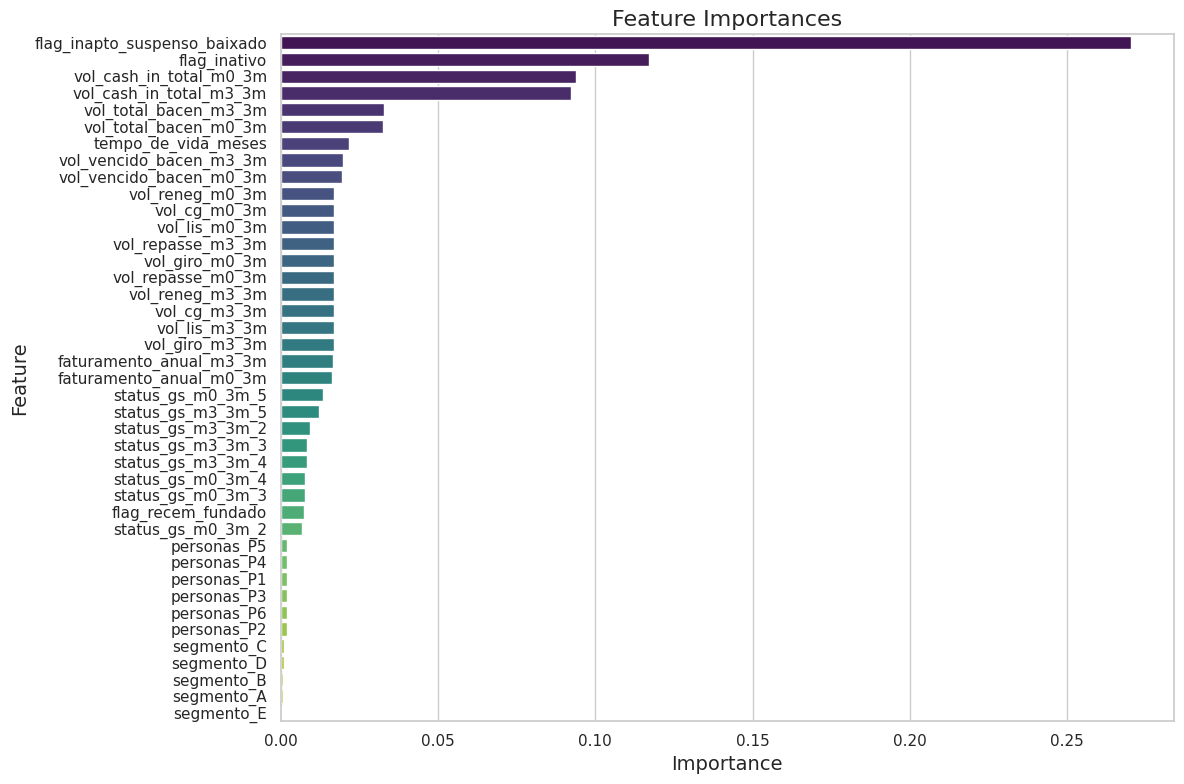

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extração das feature importances do RandomForestClassifier
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# print("Feature Importances:")
# print(feature_importance_df)

# Configura o estilo do Seaborn
sns.set(style="whitegrid")

# Cria o gráfico de barras horizontais
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance_df, palette="viridis", hue="feature", orient="h")

# Configurações adicionais
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show();

## 07. "Validação" do Classificador Analítico

To Do:

* Gráfico por segmento, de todas as personas e quantidade de CNPJs por classe
* Quantos CNPJs nós falamos que estão crescendo e inativaram/entraram em pendência
* Quantos CNPJs nós falamos que estão crescendo e passaram a ser classificados  com declinio MoM (202412 e 202411): M0 (3M) vs M3 (3M)
* Quantos CNPJs nós falamos que estão estável e inativaram/entraram em pendência
* Quantos CNPJs nós falamos que estão estável e passaram a ser classificados  com declinio MoM (202412 e 202411): M0 (3M) vs M3 (3M)
* Quantos CNPJs nós falamos que estão caindo e inativaram/entraram em pendência
* Quantos CNPJs nós falamos que estão caindo e passaram a ser classificados  com crescimento MoM (202412 e 202411): M0 (3M) vs M3 (3M)